In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms.functional as t_F
import torchvision.models as models
from torchvision import datasets, models, transforms

import cv2
import numpy as np
import pandas as pd
import json
import os
import shutil
import copy
import time
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score

plt.ion()   # interactive mode

In [4]:
data_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/'

In [5]:
# training folders
train_data_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/train'
#train_fake_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake'
#train_real_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/train/real'

In [6]:
# validation folders
val_data_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/val'
#val_fake_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/val/fake'
#val_real_dir = '/home/ec2-user/SageMaker/data/deepfake/frame_150/val/real'

In [7]:
len(os.listdir(train_fake_dir))

62356

In [8]:
len(os.listdir(train_real_dir))

12963

In [16]:
len(os.listdir(train_fake_dir)) + len(os.listdir(train_real_dir))

75319

In [9]:
os.listdir(train_real_dir)[0]

'eyekesnzuh_150.jpg'

In [225]:
'''
# ONLY USED TO SPLIT VALIDATION DATA

# move 20% of the images to the val folders for validation
# take the len of files in the real dir and * .20 and shuffle the list and shutil move the files
real_image_list = []
for image in os.listdir(train_real_dir):
    real_image_list.append(os.path.join(train_real_dir, image))
    

fake_image_list = []
for image in os.listdir(train_fake_dir):
    fake_image_list.append(os.path.join(train_fake_dir, image))
    
    
# shuffle the real_image_list
random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(real_image_list) 

np.random.shuffle(fake_image_list)


# split 20% of the images and move them to the val folder
# real images
val_split_real_images = int(len(real_image_list) * .20)
for image in real_image_list[-val_split_real_images:]:
    src = image
    fname = image.split('/')[-1]
    dst = os.path.join(val_real_dir, fname)
    shutil.move(src, dst)
    

# fake images
val_split_fake_images = int(len(fake_image_list) * .20)
for image in fake_image_list[-val_split_fake_images:]:
    src = image
    fname = image.split('/')[-1]
    dst = os.path.join(val_fake_dir, fname)
    shutil.move(src, dst)   
    
'''

In [34]:
batch_size = 50

In [11]:
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  
}

image_datasets = {'train': datasets.ImageFolder(train_data_dir, data_transforms['train']),
                  'val': datasets.ImageFolder(val_data_dir, data_transforms['val'])
               }

In [51]:
len(image_datasets['train'].imgs)

75319

In [52]:
len(image_datasets['val'].imgs)

18828

In [53]:
len(image_datasets['train'].imgs) + len(image_datasets['val'].imgs)

94147

In [13]:
# balance the dataset
# there are many more fakes than real images
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [14]:
image_datasets['train'].imgs[:5]

[('/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake/aaagqkcdis_150.jpg',
  0),
 ('/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake/aaavbjopeq_150.jpg',
  0),
 ('/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake/aaavflklag_150.jpg',
  0),
 ('/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake/aabdnomlru_150.jpg',
  0),
 ('/home/ec2-user/SageMaker/data/deepfake/frame_150/train/fake/aabdogagch_150.jpg',
  0)]

In [15]:
len(image_datasets['train'])

75319

In [17]:
weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))    

In [62]:
sampler.num_samples

75319

In [59]:
#train_size = int(len(image_datasets['train'])*.80)
#val_size = len(image_datasets['train']) - train_size

#train_size + val_size


In [19]:
sampler.weights

tensor([1.2079, 1.2079, 1.2079,  ..., 5.8103, 5.8103, 5.8103],
       dtype=torch.float64)

In [20]:
sampler.num_samples

75319

In [184]:
'''
# not using
valid_size = 0.2
num_train = len(image_datasets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


random_seed = 42
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
'''

In [152]:
#train_sampler = SubsetRandomSampler(train_idx)
#val_sampler = SubsetRandomSampler(valid_idx)

In [74]:
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=4, sampler=sampler, pin_memory=True),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=4, pin_memory=True)
              }

In [75]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
# this was the key to figuring out the issue
next(iter(dataloaders['train']))

# next(iter(dataloaders['val']))

[tensor([[[[-1.3473, -1.3473, -1.3473,  ..., -0.0972, -0.1314, -0.1314],
           [-1.3302, -1.3473, -1.3473,  ..., -0.0972, -0.1314, -0.1314],
           [-1.3130, -1.3302, -1.3473,  ..., -0.1314, -0.1314, -0.1143],
           ...,
           [ 0.0912,  0.0912,  0.0741,  ..., -0.5082, -0.5082, -0.4911],
           [ 0.1083,  0.0912,  0.0741,  ..., -0.5253, -0.5424, -0.5253],
           [ 0.1083,  0.0912,  0.0741,  ..., -0.5424, -0.5253, -0.4911]],
 
          [[-1.2829, -1.2829, -1.2829,  ..., -0.0399, -0.0399, -0.0399],
           [-1.2654, -1.2829, -1.2829,  ..., -0.0399, -0.0399, -0.0399],
           [-1.2479, -1.2654, -1.2829,  ..., -0.0399, -0.0399, -0.0224],
           ...,
           [ 0.1352,  0.1352,  0.1176,  ..., -0.3375, -0.3375, -0.3200],
           [ 0.1527,  0.1352,  0.1176,  ..., -0.3550, -0.3200, -0.3025],
           [ 0.1527,  0.1352,  0.1176,  ..., -0.3200, -0.3025, -0.2675]],
 
          [[-1.0376, -1.0376, -1.0376,  ...,  0.1999,  0.1999,  0.1999],
           [-

In [82]:
next(iter(dataloaders['val']))

[tensor([[[[-0.9192, -0.9192, -0.9192,  ..., -1.0048, -1.0219, -1.0219],
           [-0.9192, -0.9192, -0.9192,  ..., -1.0048, -1.0219, -1.0733],
           [-0.9192, -0.9363, -0.9363,  ..., -1.0048, -1.0219, -1.0733],
           ...,
           [-0.2684, -0.2684, -0.2342,  ..., -0.6623, -0.6452, -0.6281],
           [-0.2684, -0.2684, -0.2856,  ..., -0.6623, -0.6452, -0.6281],
           [-0.2856, -0.2856, -0.2856,  ..., -0.6623, -0.6452, -0.6281]],
 
          [[-0.7052, -0.7052, -0.7052,  ..., -0.8627, -0.8803, -0.8803],
           [-0.7052, -0.7052, -0.7052,  ..., -0.8627, -0.8803, -0.8803],
           [-0.7052, -0.7227, -0.7227,  ..., -0.8627, -0.8803, -0.8803],
           ...,
           [-0.0049, -0.0049, -0.0224,  ..., -0.6352, -0.6176, -0.6001],
           [-0.0049, -0.0049, -0.0224,  ..., -0.6352, -0.6176, -0.6001],
           [-0.0224, -0.0224, -0.0224,  ..., -0.6352, -0.6176, -0.6001]],
 
          [[-0.2358, -0.2358, -0.2010,  ..., -0.2707, -0.2881, -0.2881],
           [-

In [33]:
class_names

['fake', 'real']

In [24]:
dataset_sizes

{'train': 75319, 'val': 18828}

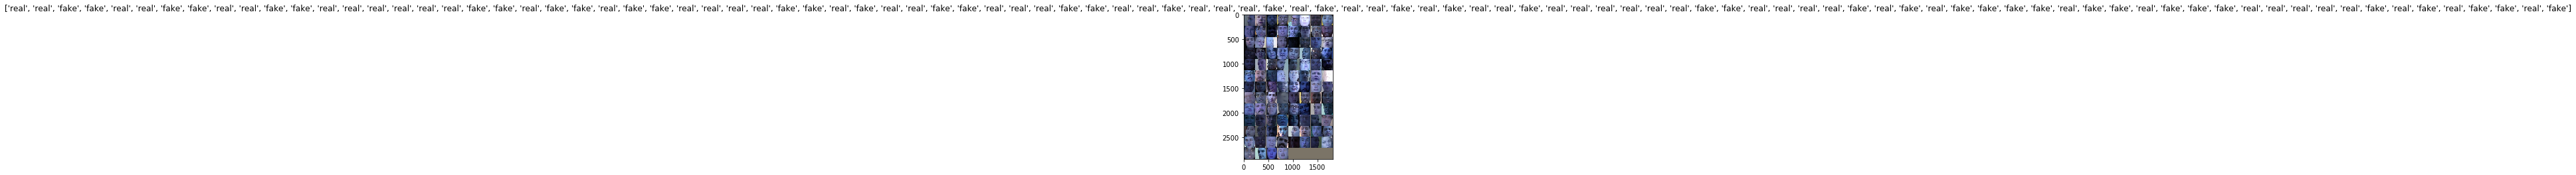

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [78]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [79]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.3449 Acc: 0.8373
val Loss: 0.3112 Acc: 0.8671

Epoch 1/5
----------
train Loss: 0.1429 Acc: 0.9447
val Loss: 0.1767 Acc: 0.9329

Epoch 2/5
----------
train Loss: 0.0845 Acc: 0.9685
val Loss: 0.2006 Acc: 0.9392

Epoch 3/5
----------
train Loss: 0.0597 Acc: 0.9791
val Loss: 0.1684 Acc: 0.9463

Epoch 4/5
----------
train Loss: 0.0397 Acc: 0.9859
val Loss: 0.1877 Acc: 0.9430

Epoch 5/5
----------
train Loss: 0.0313 Acc: 0.9891
val Loss: 0.1969 Acc: 0.9474

Training complete in 24m 50s
Best val Acc: 0.947366


In [86]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [87]:
from torchsummary import summary

In [88]:
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [89]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:
torch.save(model_ft.state_dict(), '/home/ec2-user/SageMaker/models/frame_150_balanced.pth')

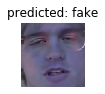

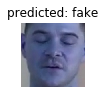

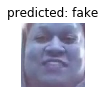

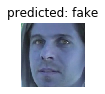

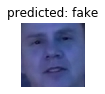

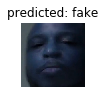

In [81]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [83]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [84]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.6239 Acc: 0.6522
val Loss: 0.7627 Acc: 0.5289

Epoch 1/5
----------
train Loss: 0.6093 Acc: 0.6679
val Loss: 0.6774 Acc: 0.6087

Epoch 2/5
----------
train Loss: 0.6037 Acc: 0.6752
val Loss: 0.6610 Acc: 0.6166

Epoch 3/5
----------
train Loss: 0.6011 Acc: 0.6748
val Loss: 0.6034 Acc: 0.6693

Epoch 4/5
----------
train Loss: 0.6020 Acc: 0.6748
val Loss: 0.6575 Acc: 0.6225

Epoch 5/5
----------
train Loss: 0.6044 Acc: 0.6729
val Loss: 0.4733 Acc: 0.7842

Training complete in 6m 19s
Best val Acc: 0.784151


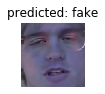

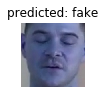

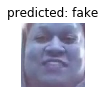

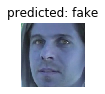

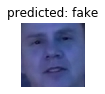

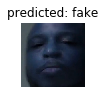

In [85]:
visualize_model(model_conv)

plt.ioff()
plt.show()